# Statistics and Trends
## Applied Data Science 1
### MSc Data Science (with placement year)
#### University of Hertfordshire
**Author:** Cristina Baron Suarez <br>
**Student ID:** 23069038 <br>
**Email:** [cb24ack@herts.ac.uk](mailto:cb24ack@herts.ac.uk)  <br>
[Github repository](https://github.com/criss-bassu/Clustering_Fitting)

In [241]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.cm as cm

The dataset provided is focused on health and physical activity measured through accelerometers, and it has been provided by a research group at the University of Malaga. I previously made use of these data for my Bachelor's Degree Final Project, and I am now contributing to the computational aspects of their ongoing work. The dataset consists of measurements of various numerical variables from over 2,000 walks carried out within the framework of the PredimedPlus study in Malaga, Spain.

In [303]:
filename = 'walkingSample.csv'
dfAll = pd.read_csv(filename).iloc[:,4:] # Read and select all columns from the 5th-on
dfAll.head()

,ENMO_mean_wb5,ENMO_sd_wb5...6,dur_wb5,dur_wb_10_90_3m_i2m_wb5,ENMO_sd_wb5...9,ENMO_mean_wb_10_90_3m_i2m_wb5,VPA_pc_wb5,wb01_pc_wb5,fragwb01
0,164.13,155.57,47.42,30.58,155.57,225.50,0.122944,0.903205,0.093392
1,107.34,61.50,41.08,32.67,61.50,116.31,0.001947,0.951315,0.076766
2,143.10,70.09,13.17,11.33,70.09,155.08,0.006074,0.949127,0.160000
3,144.03,99.40,18.17,14.67,99.40,165.60,0.009356,0.853054,0.193548
4,151.37,96.22,96.17,76.42,96.22,187.68,0.002600,0.800665,0.025974


In [246]:
# Standardize all columns
df = (dfAll - dfAll.mean()) / dfAll.std()
df.head()

,ENMO_mean_wb5,ENMO_sd_wb5...6,dur_wb5,dur_wb_10_90_3m_i2m_wb5,ENMO_sd_wb5...9,ENMO_mean_wb_10_90_3m_i2m_wb5,VPA_pc_wb5,wb01_pc_wb5,fragwb01
0,-0.242378,1.246880,-0.100319,-0.311410,1.246880,0.241197,0.429976,-0.131451,0.202049
1,-0.837426,-0.762047,-0.235242,-0.254010,-0.762047,-0.899520,-0.397596,0.408926,-0.145000
2,-0.462731,-0.578602,-0.829204,-0.840091,-0.578602,-0.494486,-0.369369,0.384353,1.592333
3,-0.452986,0.047333,-0.722797,-0.748361,0.047333,-0.384583,-0.346924,-0.694762,2.292581
4,-0.376077,-0.020578,0.937146,0.947537,-0.020578,-0.153911,-0.393136,-1.283212,-1.205162


## Statistical analysis

Below, we are going to show all major moments, usign the 'describe()' function, and adding to the resultant dataframe the skewness and the kurtosis for each column.

In [249]:
# We create an extended version of the describe function in order to add the skewness and the kurtosis
def describe_extended(data):
    """
    Adds skewness and kurtosis to the pandas describe() function.
    
    Parameter: 
    - data: The DataFrame on which to calculate descriptive statistics.
    Returns: A DataFrame with the descriptive statistics and two additional columns: skewness and kurtosis.
    """
    skewness = data.skew().round(2) # Calculates the skewness of each column. Returns only 2 decimals.
    kurtosis = data.kurtosis().round(2) # Calculates the kurtosis of each column. Returns only 2 decimals.
    
    # Transposes the DataFrames for 'skewness' and 'kurtosis', converting columns into rows
    # Renames the index of the first row to identify each metric
    skewness_df = pd.DataFrame(skewness).T.rename(index = {0: 'skewness'})
    kurtosis_df = pd.DataFrame(kurtosis).T.rename(index = {0: 'kurtosis'})
    
    # Concatenates the new DatFrames to 'describe' (which only returns 2 decimals)
    return pd.concat([data.describe().round(2), skewness_df, kurtosis_df])

In [251]:
dg = describe_extended(df)
dg

,ENMO_mean_wb5,ENMO_sd_wb5...6,dur_wb5,dur_wb_10_90_3m_i2m_wb5,ENMO_sd_wb5...9,ENMO_mean_wb_10_90_3m_i2m_wb5,VPA_pc_wb5,wb01_pc_wb5,fragwb01
count,2483.00,2483.00,2483.00,2483.00,2483.00,2483.00,2483.00,2483.00,2483.00
mean,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.34,-1.49,-0.90,-1.07,-1.49,-1.51,-0.41,-3.85,-1.62
25%,-0.59,-0.66,-0.75,-0.75,-0.66,-0.59,-0.39,-0.72,-0.73
50%,-0.23,-0.21,-0.32,-0.36,-0.21,-0.23,-0.35,0.33,-0.18
75%,0.28,0.35,0.40,0.47,0.35,0.28,-0.15,0.96,0.51
max,9.00,6.58,5.79,5.95,6.58,8.90,6.43,0.96,3.82
skewness,3.40,2.28,1.94,1.78,2.28,3.33,4.20,-0.92,0.99
kurtosis,18.93,8.59,4.82,3.97,8.59,18.36,19.64,0.07,0.86


## Clustering and fitting

Once we have the dataframe, we are now going to study the number of clusters we should use.

In [254]:
# Randomness will play a role in what follows, so we set a random seed for reproducibility
np.random.seed(1) 

We are going to use the silhouette score method in order to determine the best number of clusters. For that, we are going to compare how close data points are within a cluster and the separation between cluster.

In [257]:
def one_silhoutte(n, df):
    """
    Calculates the silhoutte score for n clusters
    """
    # set up the clusterer with the number of expected clusters
    kmeans = KMeans(n_clusters = n, n_init = 20)
    # Fit the data
    kmeans.fit(df)
    labels = kmeans.labels_
    # calculate the silhoutte score
    score = silhouette_score(df, labels)
    return score

In [305]:
# Initialize variables to track the best number of clusters and the highest silhouette score
best_n, best_score = None, -np.inf

# Iterate from 2 to 10 clusters
for n in range(2, 11):
    # Calculate the silhouette score for 'n'
    score = one_silhoutte(n, df)
    
    # if the current score is higher, update the best number of clusters and score
    if score > best_score:
        best_n = n
        best_score = score
    
    # Print the silhouette score for 'n'
    print(f"{n:2g} clusters silhouette score = {score:0.2f}")

# Print the best number of clusters
print(f"Best number of clusters = {best_n:2g}")

C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


 2 clusters silhouette score = 0.51


C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


 3 clusters silhouette score = 0.33


C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


 4 clusters silhouette score = 0.29


C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


 5 clusters silhouette score = 0.30


C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


 6 clusters silhouette score = 0.26


C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


 7 clusters silhouette score = 0.26


C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


 8 clusters silhouette score = 0.26


C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


 9 clusters silhouette score = 0.27


C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


10 clusters silhouette score = 0.25
Best number of clusters =  2


According to the silhouette score method, the best number of clusters is 2. Let's now explore it with the elbow method.

In [311]:
def elbowPlot(df, ini, end, best_n):
    """
    Plots the elbow method between ini and end
    """
    # List to store the inertia values for each number of clusters
    inertia = []
    
    # Loop through the range of cluster numbers (ini to end)
    for k in range(ini, end):
        # Perform k-means clustering with k clusters
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(df)
        # Append the inertia (sum of squared distances to cluster centers) to the list
        inertia.append(kmeans.inertia_)
    
    # Plot the inertia values VS the number of clusters
    plt.plot(range(ini, end), inertia, 'x-', label = 'Inertia')
    # Highlight the best number of clusters
    plt.scatter(best_n, inertia[best_n - ini], marker = 'o', color = 'red', facecolors = 'none', s = 50, label = 'Best number of clusters')
    plt.xlabel('Number of clusters', fontsize=14)
    plt.ylabel('Inertia', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=12)
    plt.show()
    return

C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Win

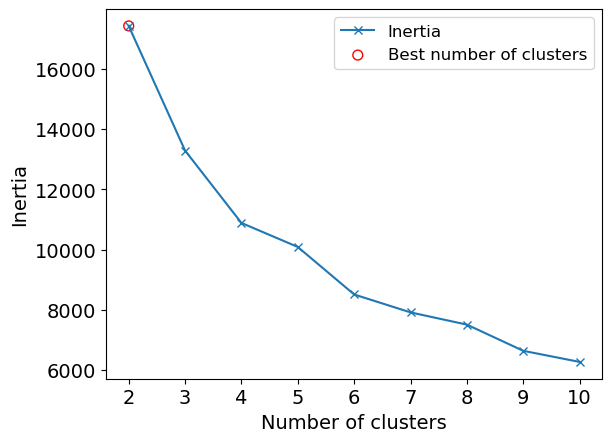

In [313]:
elbowPlot(df, 2, 11, best_n)

We will look at the actual data before choosing what should be clustered. For that, we create a pair plot and a correlation matrix.

In [264]:
def pairplot(df):
    """
    Plots pairwise relationships in a dataset, limiting it to the lower triangle.

    Parameters:
    - 'df': The DataFrame containing the data to be plotted
    """
    sns.pairplot(df, corner = True)
    plt.show()
    return

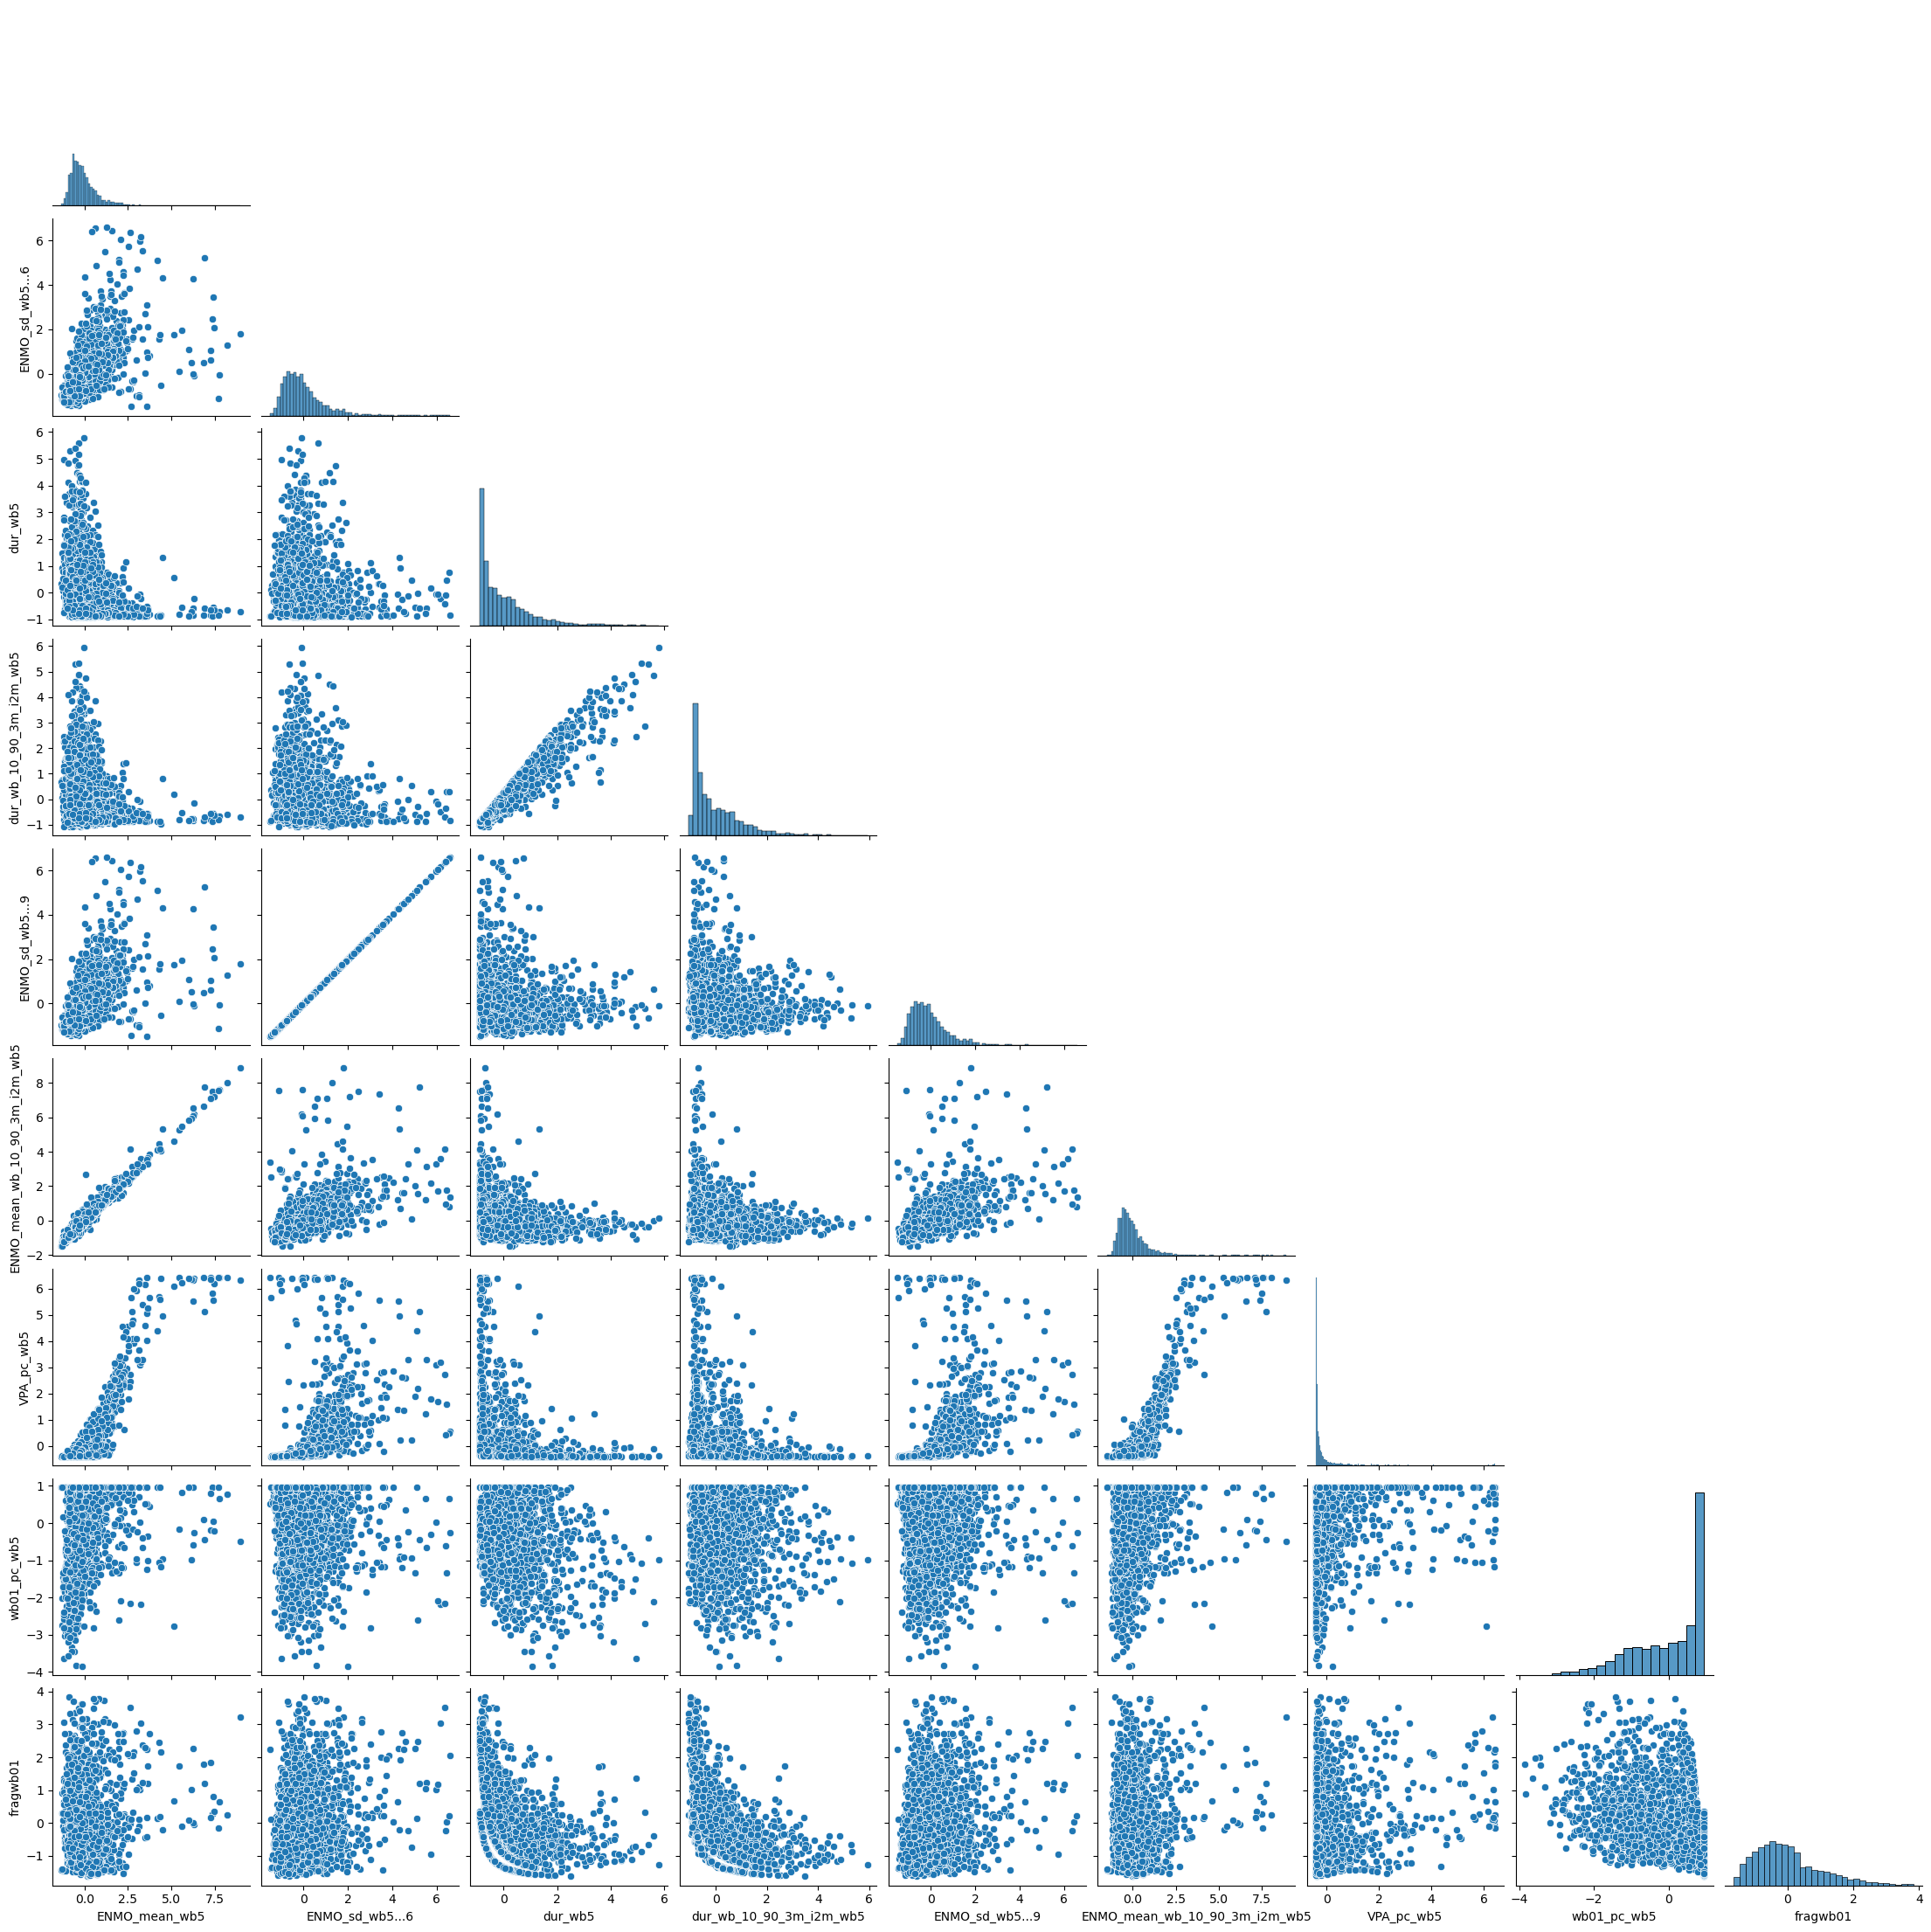

In [265]:
pairplot(df)

In [315]:
def heatmap(df):
    """
    Generates a heatmap for the correlation matrix of the 'df' dataframe.
    It applies a mask to the upper triangle of the correlation matrix to avoid redundant information.

    Parameters:
    - 'df': The DataFrame for which the correlation matrix will be computed
    """
    fig, ax = plt.subplots(figsize = (12, 10))

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(df.corr()))

    # Creates the correlation matrix
    sns.heatmap(df.corr(), ax = ax, vmin = -1, vmax = 1, cmap = 'RdBu', annot = True, mask = mask)
    plt.show()
    return

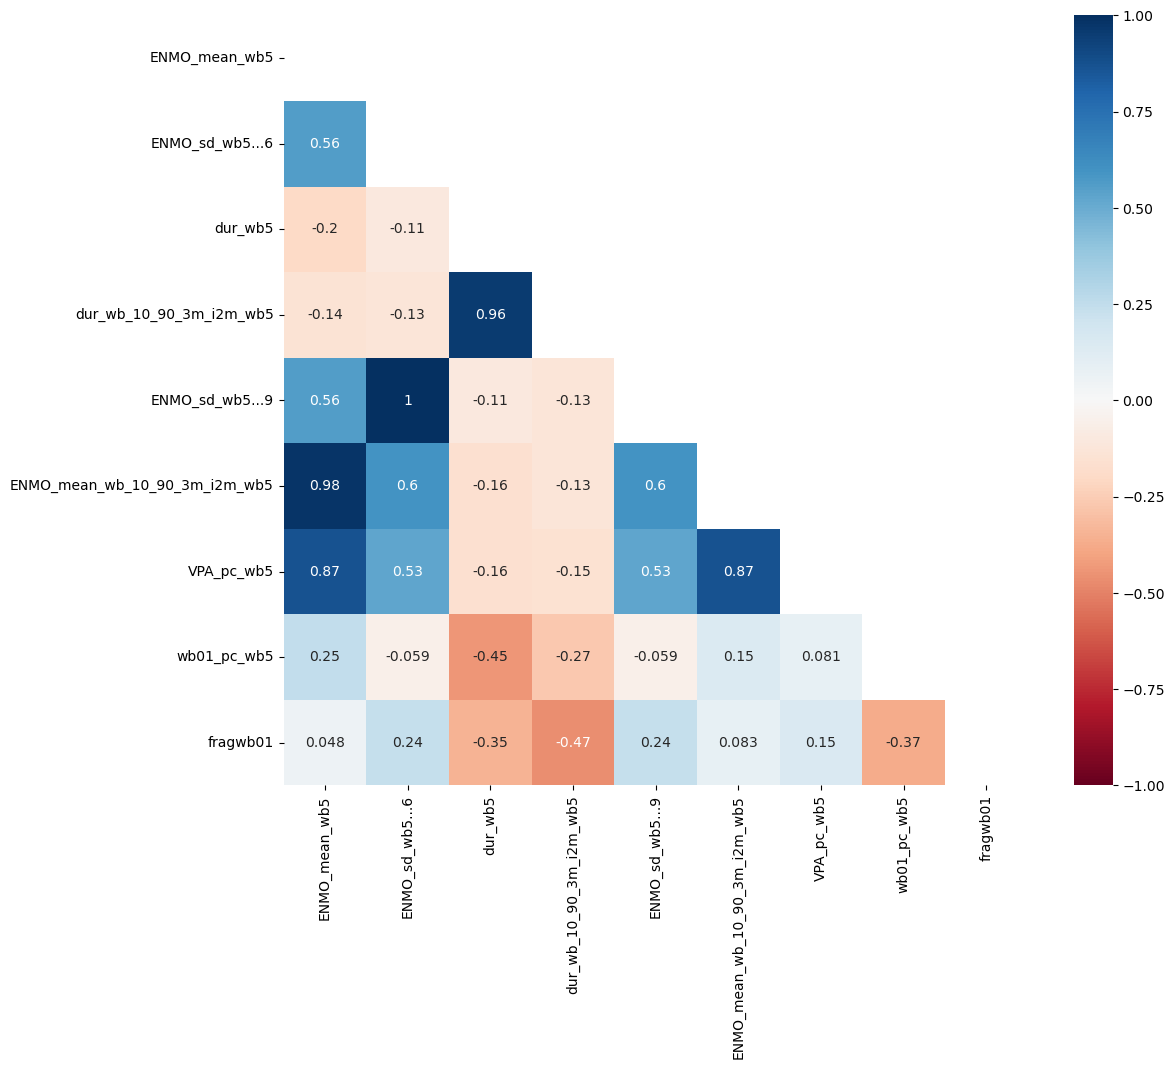

In [267]:
heatmap(df)

We could study `ENMO_sd_wb5` versus `ENMO_mean_wb5` as these are not too highly correlated.

In [317]:
def plot_histogram(df, cols, xlabels):
    """
    Plots a histogram for each specified column in a DataFrame. Each subplot shares the X and Y axis.
    
    Parameters:
    - 'df': The DataFrame containing the data to plot
    - 'cols': A list of column names in the DataFrame for which histograms will be plotted.
    - 'xlabels': A list of labels to use for the axis of the histograms
    """
    fig, axes = plt.subplots(nrows = 1, ncols = len(cols), figsize = (12, 6), sharex = True, sharey = True)

    # Iterate through the columns to plot
    for i in range(0, len(cols)):
        #Plot the histogram for each column
        axes[i].hist(df[cols[i]], bins = 20, edgecolor = 'black', color = 'skyblue')
        axes[i].set_xlabel(xlabels[i], fontsize = 14)
        axes[i].set_ylabel('Frequency', fontsize = 14)
        axes[i].tick_params(axis = 'x', labelsize = 14)
        axes[i].tick_params(axis = 'y', labelsize = 14)
        axes[i].grid()
    
    plt.show()
    return

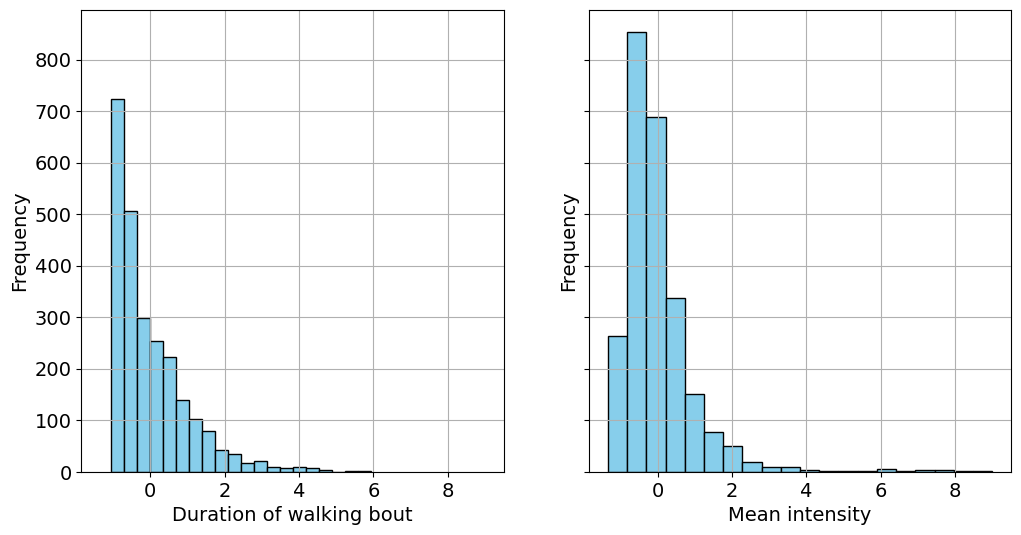

In [270]:
cols = ['dur_wb_10_90_3m_i2m_wb5', 'ENMO_mean_wb5']
xlabels = ['Duration of walking bout', 'Mean intensity']
plot_histogram(df, cols, xlabels)

In [271]:
def plot_regresion(df, vars, xlabels):
    """
    Plots a scatter plot and a linear regression line for the variables we want to study.
    Aim: Observe how different variables correlate with each other.
    
    Parameters: 
    - 'df' : The DataFrame containing the data
    - 'vars': A list with the variables to be studied
    - 'xlabels': A list with the labels of these variables
    """
    # Creates the figure and the axes
    fig, ax = plt.subplots(dpi = 144, figsize = (6, 4))

    # Generates a scatter plot comparing the first variable against the second variable
    ax.scatter(df[vars[0]], df[vars[1]], marker = 'o', s = 10)

    # Sets a linear regression line (degree 1) to the data
    # Saves the results in the coefficients of the equation of the line
    m, b = np.polyfit(df[vars[0]], df[vars[1]], 1)
    
    # Draws a line in the graph given the axes X and the equation of the line
    ax.plot(df[vars[0]], m * df[vars[0]] + b, color = "red", label = "Regression line")

    ax.grid(True)
    ax.set_xlabel(xlabels[0], fontsize = 14)
    ax.set_ylabel(xlabels[1], fontsize = 14)
    ax.tick_params(labelsize = 12)
    ax.legend(fontsize = 12)
    
    plt.show()
    return

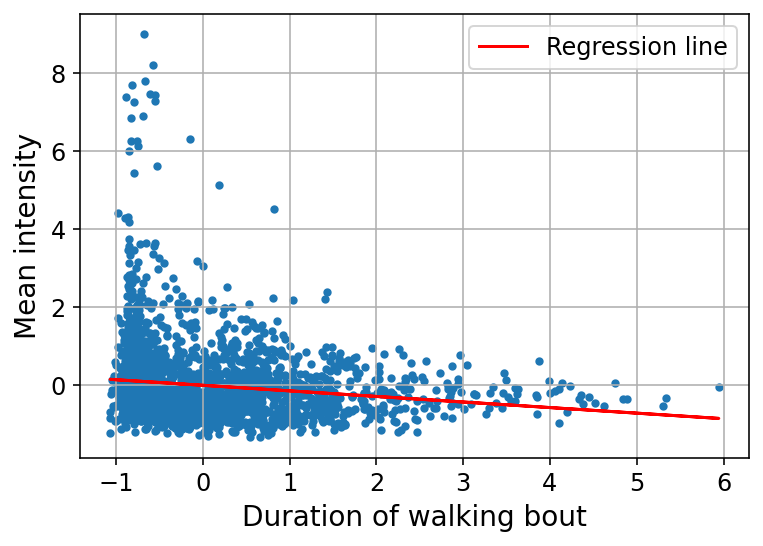

In [272]:
plot_regresion(df, cols, xlabels)

In [319]:
df_clust = df[cols].copy()
scaler = RobustScaler()

# Fit the scaler to the data and transform it to normalized values
norm = scaler.fit_transform(df_clust)

In [274]:
def plot_fitted(cols, labels, xlabels, df, xkmeans, ykmeans, centre_labels):
    """
    Plots clustered data as a scatter plot, with centres shown.

    Parameters:
    - 'cols': list with the column names for the x and y data
    - 'labels': array of cluster labels for each data point in df
    - 'xlabels': list with the labels for the X and Y axis
    - 'df': DataFrame containing the data to be plotted
    - 'xkmeans': array of the x coordinates of the cluster centers
    - 'ykmeans': array of the y coordinates of the cluster centers
    - 'centre_labels': array of labels for the cluster centers
    """
    # Generate a color map with unique colors for each cluster label
    colours = plt.cm.Set1(np.linspace(0, 1, len(np.unique(labels))))
    cmap = ListedColormap(colours)

    # Create a scatter plot of the data points
    fig, ax = plt.subplots(dpi = 144)
    scatter = ax.scatter(df[cols[0]], df[cols[1]], c = labels, cmap = cmap, marker = 'o', alpha = 0.25, s = 5, label = 'Data')

    # Plot the cluster centers
    ax.scatter(xkmeans, ykmeans, c = centre_labels, cmap = cmap, marker = 'x', s = 100, label = 'Estimated Centres')

    # Add a color bar and legend
    cbar = fig.colorbar(scatter, ax = ax)
    cbar.set_ticks(np.unique(labels))
    cbar.set_ticklabels(['Cluster {}'.format(int(i)) for i in np.unique(labels)])

    # Set labels and legend
    ax.legend()
    ax.set_xlabel(xlabels[0])
    ax.set_ylabel(xlabels[1])

    plt.show()
    return

C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


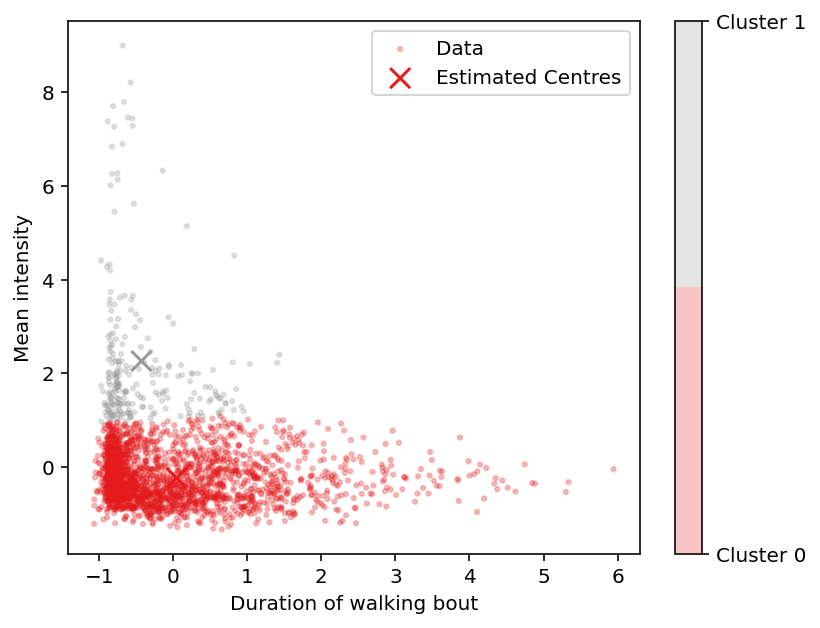

C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


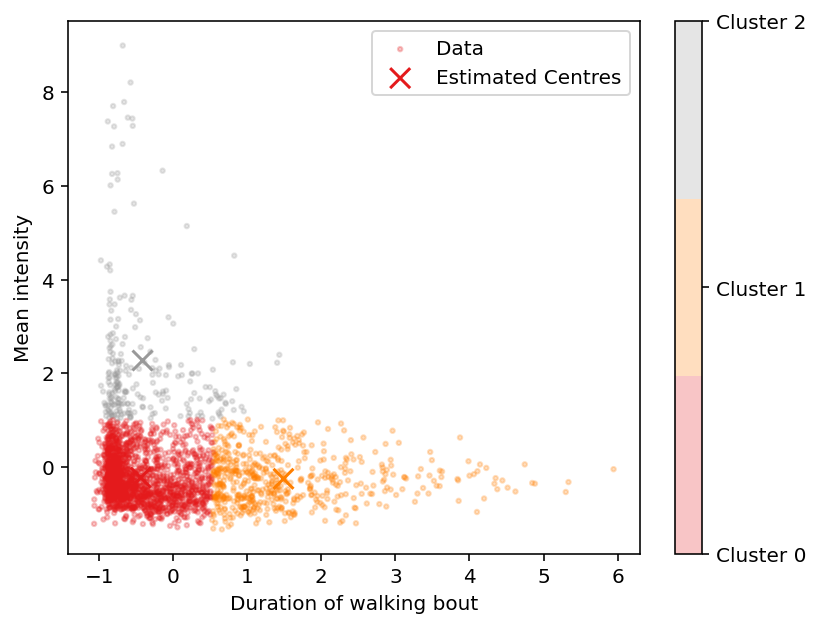

C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


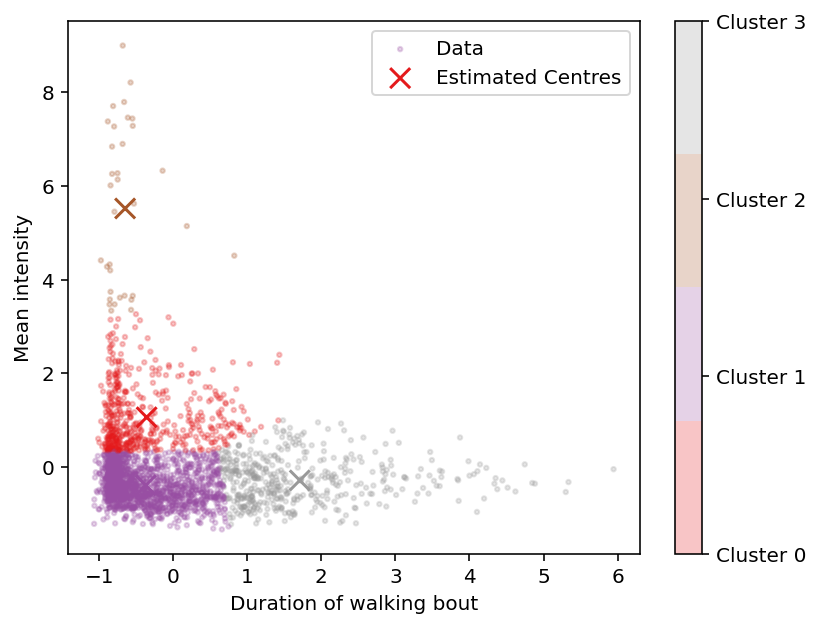

C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


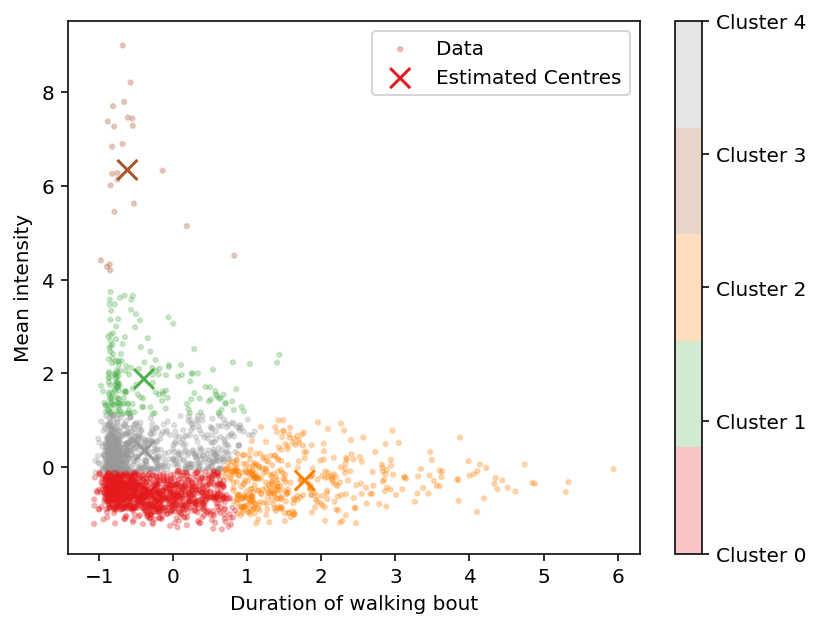

C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


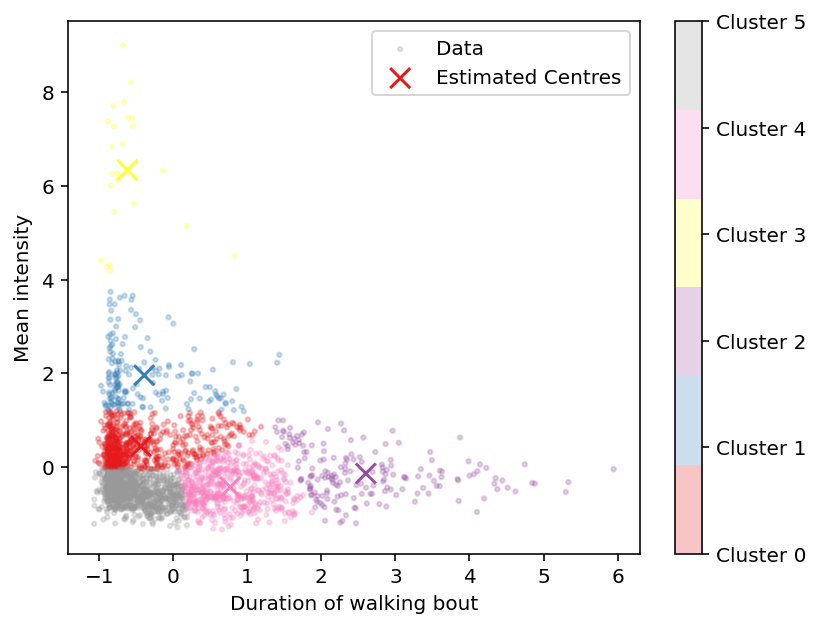

C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


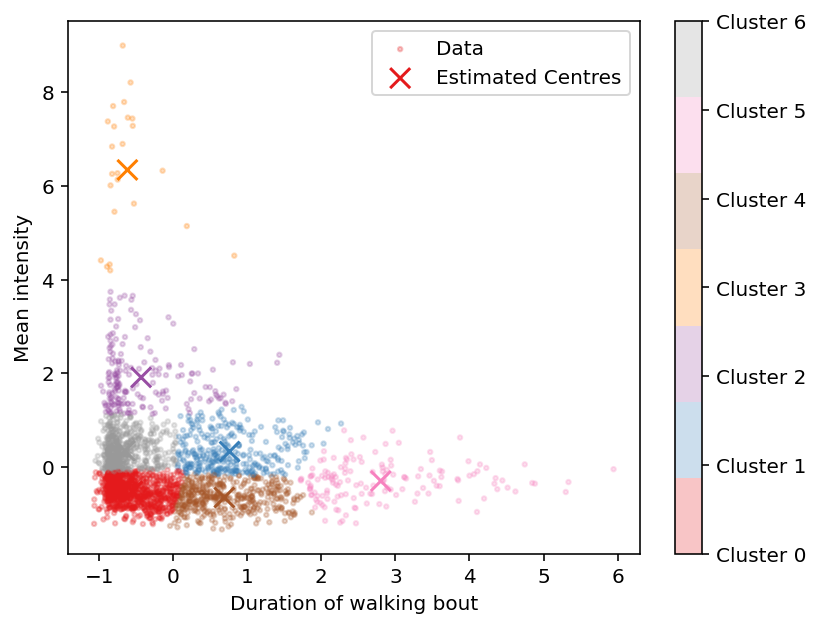

C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


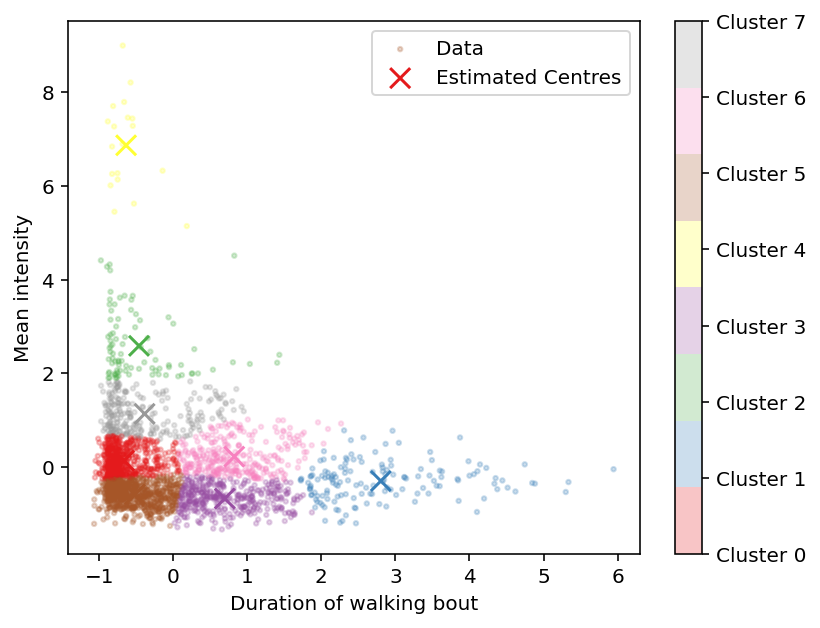

C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


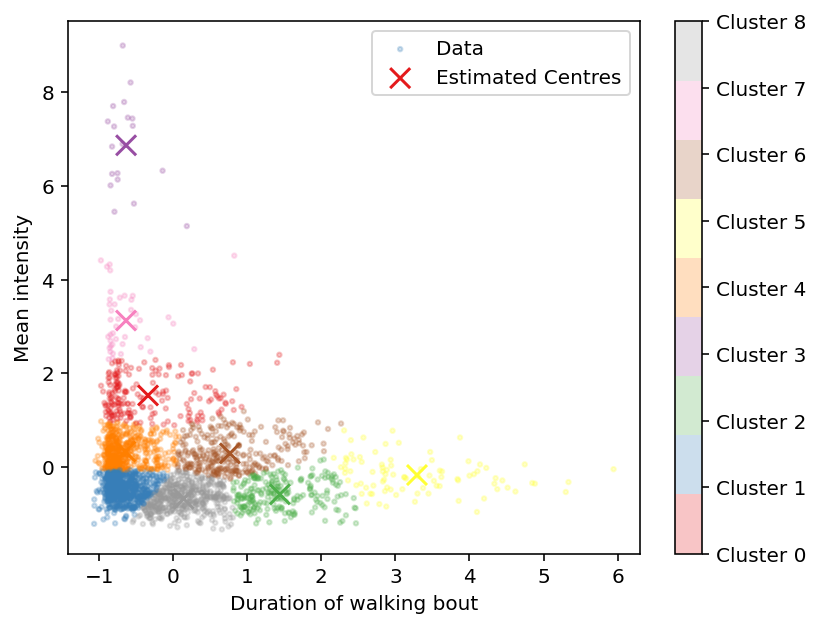

C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


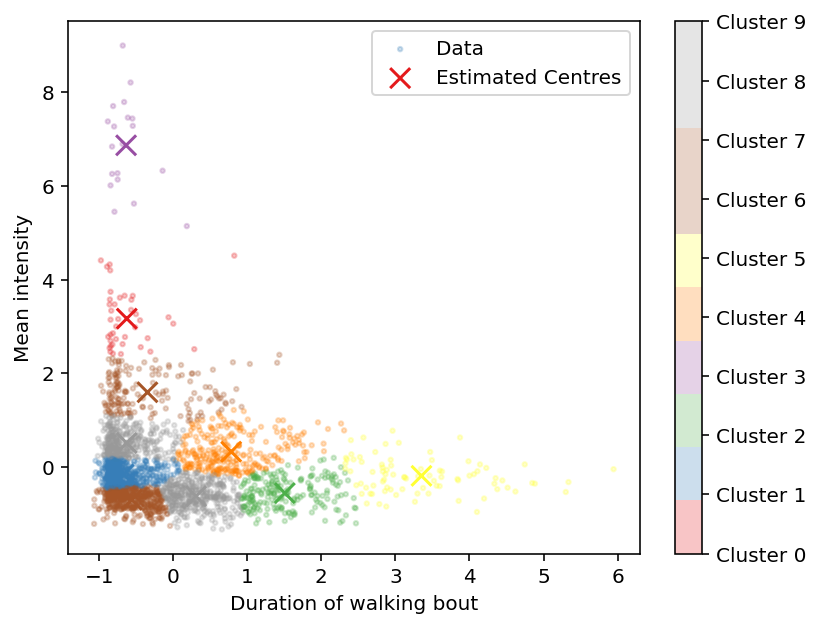

In [323]:
# Bring the normalized data back to its original scale
inv_norm = scaler.inverse_transform(norm)

# Iterate through a number of clusters
for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, n_init = 20)
    kmeans.fit(norm) # fit done on x,y pairs
    # Extract the cluster labels for each data point
    labels = kmeans.labels_
    # The estimated cluster centres
    cen = scaler.inverse_transform(kmeans.cluster_centers_) # Transform centers back to the original scale
    xkmeans = cen[:, 0] # X-coordinates of cluster centers
    ykmeans = cen[:, 1] # Y-coordinates of cluster centers
    # Predict cluster labels for the estimated cluster centers
    cenlabels = kmeans.predict(kmeans.cluster_centers_)
    plot_fitted(cols, labels, xlabels, df, xkmeans, ykmeans, cenlabels)

At this point, I presented the data and preliminary results to the researchers at the University of Malaga who initially proposed to explore this data. Although the elbow plot and silhouette index suggest using 2 clusters, the researchers prioritized interpretability over these metrics. Consequently, they found the four-cluster configuration more promising for their ongoing research. They believe that examining these four clusters -reflecting the duration and intensity of walking bouts measured in older adults in Malaga - could potentially yield insights into health outcomes beyond the scope of the current work. Therefore, I decided to proceed with the analysis using four clusters.

In [327]:
# Specify the number of clusters
numClusters = 4

# Initialize the KMeans clustering model with the specified number of clusters
kmeans = KMeans(n_clusters = numClusters)

# Fit the KMeans model to the datFrame
kmeans.fit(df)

# Predict the cluster labels for each data point in the dataset
y_kmeans = kmeans.predict(df)

# New column to store the cluster labels
df[f'Cluster{numClusters}'] = y_kmeans

# Display the number of data points in each cluster
df[f'Cluster{numClusters}'].value_counts()

C:\Users\cbaro\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


Cluster4
0    1282
1     548
3     524
2     129
Name: count, dtype: int64

In [329]:
# Reduce the dataset to 3 components
pca = PCA(n_components = 3)
columns = ['PC1', 'PC2','PC3']

# Fit the PCA model and transform the data to the dataset's principal components
principalComponents = pca.fit_transform(df)

# New DataFrame to store the principal components
principalDf = pd.DataFrame(data = principalComponents, columns = columns)

# Add the cluster labels to the new DataFrame
principalDf[f'Cluster{numClusters}'] = df[f'Cluster{numClusters}']

principalDf.head()

,PC1,PC2,PC3,Cluster4
0,1.281694,0.053335,0.798863,1
1,-1.516806,-1.197290,-0.336138,0
2,-0.570565,-2.068479,0.596888,0
3,-0.018517,-1.802217,2.011944,0
4,-0.915510,2.612584,0.267541,3


In [331]:
def boxplot(data, columns, numClusters):
    """
    Plots abox plots for each distribution of a principal component (PC) across the number of clusters specified.

    Parameters:
    - 'data': The DataFrame containing the data to plot
    - 'columns': A list of principal components
    - 'numClusters': The number of clusters used in the dataset
    """
    plt.figure(figsize=(10, 5))

    # Iterate through the principal components
    for i in range(0, len(columns)):
        # Create a subplot for each principal component
        plt.subplot(1, len(columns), i+1)
        sns.boxplot(x = f'Cluster{numClusters}', y = f'PC{i+1}', data = data, color = 'skyblue')

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.4)
    plt.show()
    return

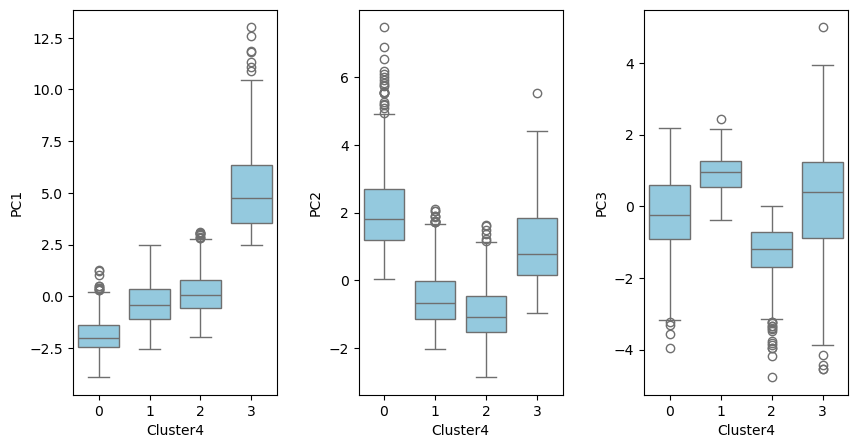

In [280]:
boxplot(principalDf, columns, numClusters)

## Preliminary Feedback

As I am not a specilist in physical activity I cannot interpret the meaning of the clusters from the point of viow of health researchers, but this is the feedback that I received and this will be the object of further research.

Based on the analysis, it appears there are four types of walks:
- **Group 1:** Mixed, less intentional walks (e.g., short trips or social strolls) that are generally short in duration.
- **Group 2:** Mixed, less intentional walks (e.g., short trips or social strolls) that tend to be longer.
- **Group 3:** Moderate walks that appear more purposeful, lasting around 45 minutes.
- **Group 4:** Intense walks, with a duration of around 30 minutes.

Perhaps these styles of walking, measured using acclerometers, could be used as predictors for some health outcomes in patients of the PredimedPlus study.